## Creating a CANDELS-based photometry catalog used as input to the Akari sim engine

2021.06.27-07.02  S. Rodney

This nb creates a new CANDELS-based photometry catalog that can be used as an input into the Akari sim engine (the M.Troxel pixel-level galaxy simulation toolkit used by Kevin Wang at Duke).

This nb begins with the official v4.1 3DHST catalogs from `3dhst.research.yale.edu` and constructs an output catalog with the necessary information for running both the Akari pixel-level sims and the SNANA supernova + host sims.  Specifically, we require 

 1. redshift
 1. observer-frame magnitudes in Roman filters
 1. galaxy size (kron_radius)
 1. ellipticity parameters (a, b)
 1. derived physical properties from various CANDELS catalogs: mass, star formation rate
 1. 13 coefficients for constructing a simulated SED (the "specbasis coefficients" for use with 13 EAZYpy templates that SNANA knows about)




Note that the catalog used in previous iterations of our simulation work was a Roman+LSST CANDELSbased photometry catalog, originally produced by the WFIRST HLS SIT (Hemmati, Capak et al) by remapping real CANDELS galaxies onto a larger area, as described here  https://www.roman-hls-cosmology.space/products/ under "LSST+ Roman Simulated Photometric Catalog".  **NOTE that the version we used had about 38k entries, and it has been modified to give the original CANDELS team ID number for each galaxy in the `id` column.**  The version you can download from the link above has about 44k entries, and does not have the necessary CANDELS team IDs.  

We stopped using that `photcat` because it is missing some columns that we need for running SNANA simulations, and also imposes a weak-lensing selection cut (see Hemmati+ 2019), which is not desirable for our SN sims. 

### Preamble 
Imports and global variables.

In [2]:
# comment out #inline and restart kernel for interactive pop-out plotting
%matplotlib inline   

In [3]:
import os
import time
from copy import deepcopy
from string import ascii_lowercase
from importlib import reload

import numpy as np
from numpy import ma

from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns

from astropy.io import fits
from astropy.table import Table, Column, vstack, hstack, join
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()  

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7f9f20b76750>

In [4]:
import romanz
import eazyseds

### A.  Create the simulation catalog

Set REBUILD = True and iterate the version number if you want to build a new product from scratch. 

The function "prepare_simulation_catalog()" does all the steps.  It can take 30-60 minutes to run (most of the time is spent in generating EAZY SED sims and integrating them to get synthetic magnitudes in Roman bandpasses). 

To run this, you will need to have the CANDELS+3DHST 'master' and 'photometric' catalogs from Skelton et al. 2014 and Momcheva et al. 2016 in the 'data' subdirectory.  Get them from here: 

https://archive.stsci.edu/missions/hlsp/3d-hst/RELEASE_V4.0/Photometry/3dhst_master.phot.v4.1.tar



In [ ]:
start = time.time()
reload(eazyseds)
reload(romanz)

REBUILD = True
version = 'v1.5'

if REBUILD:
    threedhstcat = romanz.Catalog3DHST()
    threedhstcat.prepare_simulation_catalog()
    threedhstcat.write_simulation_catalog_as_fits(
        f"data/3dhst_sim_input_cat_{version}.fits", overwrite=True)
    threedhstcat.write_simulation_catalog_as_hostlib(
        f"data/3dhst_sim_input_cat_{version}.hostlib", overwrite=True)
else:
    print(f"Shortcut. Loading {version}")
    threedhstcat = romanz.Catalog3DHST(
        f'data/3dhst_sim_input_cat_{version}.fits')
end = time.time()
dtsec=end-start
dtmin = dtsec / 60.
print(f"Finished in {dtsec:.1f} seconds ({dtmin:.1f} min)")

In [6]:
version = 'v1.5'

reload(romanz)
simcat = romanz.CatalogBasedRedshiftSim()
simcat.read_galaxy_catalog(f"data/3dhst_sim_input_cat_{version}.fits")
simcat.assign_snhost_prob(snr_model='AH18PW')
simcat.pick_host_galaxies(nsn=5000)


Added/updated relative SN rate column using AH18PW model
Assigned 5000 SNe to hosts using snr_AH18_piecewise probabilities.


In [7]:
snr = simcat.galaxies['snr_AH18_piecewise']
logsnr = np.log10(snr)
logsfr = simcat.galaxies['logsfr']
logmass = simcat.galaxies['logmass']
logssfr = simcat.galaxies['logssfr']
logssnr = logsnr - logmass

hsnr = simcat.snhosts['snr_AH18_piecewise']
hlogsnr = np.log10(hsnr)
hlogsfr = simcat.snhosts['logsfr']
hlogmass = simcat.snhosts['logmass']
hlogssfr = simcat.snhosts['logssfr']
hlogssnr = hlogsnr - hlogmass


/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


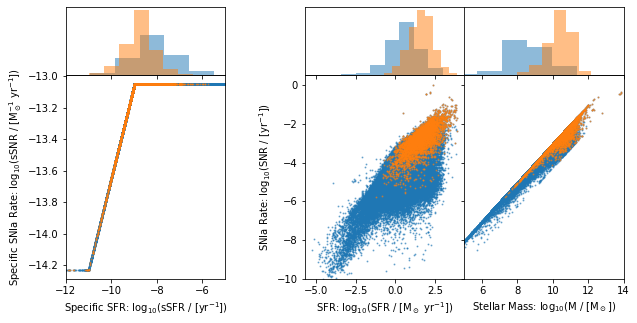

In [8]:
fig = plt.figure(constrained_layout=True, figsize=[10,5])
widths = [2, 1, 2, 2]
heights = [1, 3]
gs = fig.add_gridspec(ncols=4, nrows=2, 
                      width_ratios=widths,
                      height_ratios=heights)

ax1b = fig.add_subplot(gs[1,0])
ax2b = fig.add_subplot(gs[1,2])
ax3b = fig.add_subplot(gs[1,3], sharey=ax2b)

ax1a = fig.add_subplot(gs[0,0], sharex=ax1b)
ax2a = fig.add_subplot(gs[0,2], sharex=ax2b)
ax3a = fig.add_subplot(gs[0,3], sharex=ax3b)


ax1b.plot(logssfr, logssnr, marker='.', ms=2, ls=' ', alpha=0.5)
ax1a.hist(logssfr, density=True, alpha=0.5)
ax1a.hist(hlogssfr, density=True, alpha=0.5)

ax2b.plot(logsfr, logsnr, marker='.', ms=2, ls=' ', alpha=0.5)
ax2a.hist(logsfr, density=True, alpha=0.5)
ax2a.hist(hlogsfr, density=True, alpha=0.5)

ax3b.plot(logmass, logsnr, marker='.', ms=2, ls=' ', alpha=0.5)
ax3a.hist(logmass, density=True, alpha=0.5)
ax3a.hist(hlogmass, density=True, alpha=0.5)

ax1b.plot(hlogssfr, hlogssnr, marker='.', ms=2, ls=' ', alpha=0.5)
ax2b.plot(hlogsfr, hlogsnr, marker='.', ms=2, ls=' ', alpha=0.5)
ax3b.plot(hlogmass, hlogsnr, marker='.', ms=2, ls=' ', alpha=0.5)

def hide_ticklabels(ax):
    ax.yaxis.set_ticks([])
    ax.yaxis.set_ticklabels([])
    plt.setp(ax.xaxis.get_ticklabels(), visible=False)

    
hide_ticklabels(ax1a)
hide_ticklabels(ax2a)
hide_ticklabels(ax3a)
plt.setp(ax3b.yaxis.get_ticklabels(), visible=False)

ax1b.set_ylabel('Specific SNIa Rate: log$_{10}$(sSNR / [M$_\odot^{-1}$ yr$^{-1}$])')
ax2b.set_ylabel('SNIa Rate: log$_{10}$(SNR / [yr$^{-1}$])')

ax1b.set_xlabel('Specific SFR: log$_{10}$(sSFR / [yr$^{-1}$])')
ax2b.set_xlabel('SFR: log$_{10}$(SFR / [M$_\odot$ yr$^{-1}$])')
ax3b.set_xlabel('Stellar Mass: log$_{10}$(M / [M$_\odot$])')

ax1b.set_xlim(-12, -5)
ax2b.set_ylim(-10, 0.5)
ax3b.set_xlim(5, 14)

plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig(os.path.expanduser("~/Desktop/3dhst_snia_rate.pdf"))
#ax2.plot(logssfr, snr, marker='.', ms=2, ls=' ', alpha=0.5)
#ax1.set_ylim(-0.01, 0.1)

In [ ]:
simcat.make_sfrmass_figure(cmap='inferno')

##### Figure Caption: 

Stellar population properties of the galaxy catalog used as input for Roman SN survey simulations.  Shading in each panel shows the distribution of the entire galaxy catalog (~112,000 entries), with logarithmic scaling.  Overlaid contours show a representative sampling of Type Ia SN host galaxies, drawn according to the specific-star-formation-rate-based model from Andersen & Hjorth 2018.   Panel (a) presents the stellar mass vs redshift distribution; (b) shows star formation rate vs redshift; (c) plots star formation rate against stellar mass.   The Type Ia SN host galaxy population is strongly skewed to higher mass and more actively star forming galaxies at all redshifts. 

In [ ]:
hmag = simcat.galaxies['h158']
z = simcat.galaxies['z']

plt.hexbin(z, hmag, extent=[0,6,18,28], bins='log', zorder=1, cmap='viridis')
ax = plt.gca()
ax.set_xlim(0,6)
ax.set_ylim(18,28)
plt.xlabel('Redshift')
plt.ylabel('AB mag in Roman H158 band')


hsn = simcat.snhosts_df['h158']
zsn = simcat.snhosts_df['z']

sns.kdeplot(x=zsn, y=hsn, zorder=2, ax=ax, color='w', levels=5)
ax.invert_yaxis()

In [ ]:
iz2 = np.where((simcat.galaxies['z']>1.5) & (simcat.galaxies['z']<2.5))[0]


In [ ]:
rmag = simcat.galaxies['r062'][iz2]
zmag = simcat.galaxies['z087'][iz2]
fmag = simcat.galaxies['f184'][iz2]

plt.hexbin(fmag, rmag-zmag, extent=[18,28,-2,3], bins='log', zorder=1, cmap='viridis')
ax = plt.gca()
ax.set_ylim(-2,3)
ax.set_xlim(28,18)
plt.ylabel('R062-Z087')
plt.xlabel('F184')


#hsn = simcat.snhosts_df['h158']
#zsn = simcat.snhosts_df['z']

#sns.kdeplot(x=zsn, y=hsn, zorder=2, ax=ax, color='w', levels=5)
#ax.invert_yaxis()

## UP NEXT:

- [x] integrate over Roman bandpasses to get RYJHF mags
- [x] Add those mags into the specsiminput catalog
- [x] remake the hostlib.  
- [x] post it for Kevin et al.
- [x] add plots to the redshift sim doc and Kevin's paper
- [ ] update the starterkit